In [ ]:
# 한글 폰트를 구글 코랩에서 설치하기 위한 과정
# 아래 3줄의 코드를 실행시킨 다음 위의 메뉴에서 런타임 - 런타임 다시 시작을 눌러 런타임을 재실행시킨다
# 런타임 다시 시작을 한 후에는 이 박스의 코드는 다시 실행하지 말고 아래의 박스부터 코드를 진행함

!apt-get update &> /dev/null
!pip install --upgrade pip

!apt -qq -y install fonts-nanum > /dev/null
!sudo fc-cache -fv > /dev/null
!rm ~/.cache/matplotlib -rf > /dev/null

!pip install sentence-transformers -q
!pip install umap-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2




In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
from sentence_transformers import SentenceTransformer
from openai import OpenAI
import os

from google.colab import drive
drive.mount('/content/drive')

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=15)
plt.rc('font', family='NanumBarunGothic')
%config InlineBackend.figure_format = 'retina'
# fm._rebuild()

%matplotlib inline

Mounted at /content/drive


In [ ]:
df_filtered = pd.read_csv('/content/drive/MyDrive/Colab/사다리 담론 연구/df_filtered_final.csv', encoding='utf-8', lineterminator='\n')

df_filtered

,Date,Url,Title,Content,News,Style,Year,YearMonth,Char,Nouns
0,2025.06.30,https://www.chosun.com/economy/realty/realesta...,"이상경 국토부 1차관 임명…""불로소득 차단·개발이익 환수 개혁론자""",[땅집고] 국토교통부 제1차관에 이상경 전 가천대 도시계획 조경학부 교수가 임명됐다...,Chosun,Con,2025,202506.0,311.0,땅집 국토 교통부 차관 이상경 가천대 도시 계획 조경 학부 교수 임명 이상경 신임 ...
1,2025.06.30,https://www.chosun.com/economy/real_estate/202...,“갚을 능력 있는데…” 3040 맞벌이들 대출 규제 ‘날벼락’,서울 동작구의 이모(39)씨 부부는 지난 27일 정부의 부동산 대책을 보고 이사 계...,Chosun,Con,2025,202506.0,471.0,서울 동작구 부부 정부 부동산 대책 보고 이사 계획 포기 남편 아내 기업 부부 합산...
2,2025.06.28,https://www.chosun.com/culture-life/book/2025/...,하루에 1만6000원 이상 지출하면 당신은 ‘중산층’입니다,중산층 연대기 호미 카라스 지음｜배동근 옮김｜arte｜372쪽｜3만원 책의 서문을 ...,Chosun,Con,2025,202506.0,556.0,중산 연대기 호미 카라스 서문 기사 글로벌 중산 가능 저자 세계 인구 절반 중산 부...
3,2025.06.27,https://www.chosun.com/economy/money/2025/06/2...,"“이젠 현금 있어야 한강변 집 산다”… 연봉 2억 직장인, 대출액 12억→6억 ‘반토막’","수도권과 규제지역 주택담보대출(주담대) 한도가 6억원 이내로 제한되면서, 연봉 2억...",Chosun,Con,2025,202506.0,356.0,수도 규제 지역 주택 담보 대출 주담대 한도 이내 제한 연봉 금융 소비자 대출 가능...
4,2025.06.27,https://www.chosun.com/economy/real_estate/202...,집값 잡으려 내 놓은 강력한 대출 규제…“단기 극약 처방에 당분간 거래 줄 것”,정부가 서울 아파트 매매 가격을 가라앉히기 위해 꺼내 든 대출 규제에 전문가들은 ‘...,Chosun,Con,2025,202506.0,244.0,정부 서울 아파트 매매 가격 대출 규제 전문가 단기 극약 처방 평가 주택 담보 대출...
...,...,...,...,...,...,...,...,...,...,...
4041,2007-10-28,https://www.hani.co.kr/arti/politics/politics_...,이명박 “진학·취업 등 빈곤층 계층할당제 도입”,"한나라당 이명박(李明博) 대선후보는 28일 진학과 장학금 지원, 공무원 및 공공기관...",Hankyoreh,Pro,2007,NaN,400.0,한나라당 이명박 대선 후보 진학 장학금 지원 공무원 공공 기관 취업 일정 비율 빈곤...
4042,2007-03-14,https://www.hani.co.kr/arti/opinion/column/196...,[나라살림가족살림] 바닥으로의 질주 / 류동민,"어떻게 바뀔지 모르는 것이 사람 마음이기는 하지만, 오래 전부터 주식투자는 하지...",Hankyoreh,Pro,2007,NaN,415.0,사람 마음 주식 투자 결심 얼마 쌈짓돈 은행 창구 직원 권유 펀드 가입 화근 경제학...
4043,2007-01-18,https://www.hani.co.kr/arti/opinion/column/184...,"[기고] 등록금 후불제, 당장 실시하자 / 노중기",지금 대학은 입시철이다. 전쟁과도 같은 입시경쟁을 치르고 있는 젊은이들을 바라보...,Hankyoreh,Pro,2007,NaN,424.0,대학 입시 전쟁 입시 경쟁 젊은이 심정 착잡 수도 지방 국립 사립 서열 체계 대학 ...
4044,2007-01-09,https://www.hani.co.kr/arti/society/society_ge...,[단독] 강남·외고 출신 28%…‘그들만의 법원’ 될라,새로 임관하는 판사 가운데 상류층 또는 중상류층 자녀들이 많이 다니는 서울 강남...,Hankyoreh,Pro,2007,NaN,385.0,임관 판사 가운데 상류 중상류 자녀 서울 강남 지역 고교 서울 외국어고 출신자 비율...


# 딥러닝

In [ ]:
# 한국어 뉴스, 담론 분석에 적합한 모델 추천
model = SentenceTransformer("jhgan/ko-sroberta-multitask")

# 문장 임베딩
embeddings = model.encode(df_filtered['Content'].tolist(), show_progress_bar=True)

print("임베딩 결과:", embeddings.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

임베딩 결과: (4046, 768)


* 차원 축소?
    - 임베딩 벡터는 보통 수백 차원(예: 384, 768) 이라서 그대로는 2D 그래프로 볼 수 없음
    - 고차원을 2차원으로 줄여서 문서/문장들이 어떻게 군집을 이루는지(어떤 그룹이 서로 비슷하고/다른지)를 산점도로 표현
    - 산점도를 통해 주제별로 문서가 어떻게 뭉치는지 논란 관련/비관련/특정 아티스트/시기별 문서가 어디에 분포하는지 시각적으로 확인 가능

* UMAP(Uniform Manifold Approximation and Projection)
    - t-SNE와 비슷한 비선형 차원 축소 기법
    - 지역 구조(local structure) 를 잘 보존하면서도 전체 구조(global structure) 도 어느 정도 유지
    - t-SNE보다 속도가 빠르고, 큰 데이터에도 조금 더 안정적

* 주요 파라미터
    - n_neighbors=10 : 각 점(문서)이 주변 몇 개 이웃을 기준으로 근접 구조를 배울지 결정
        - 값이 작으면 더 촘촘한, 국소적인 군집이 생김
        - 값이 크면 더 넓은 구조를 함께 보려는 경향

    - min_dist=0.3 : 점들 사이의 최소 거리를 제어(점들이 얼마나 뭉칠 수 있는지)
        - 0에 가까울수록 군집이 더 빡빡하게 모임
        - 값이 커질수록 점들이 퍼져서 더 매끈한 분포

In [ ]:
# 384차원에서 2차원 축소
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)  # UMAP 모델 생성: 이웃 수=10, 점 간 최소 거리=0.3, 재현성을 위한 시드=42
embedding_2d = umap_model.fit_transform(embeddings)                    # 384차원 임베딩(embeddings)을 2차원으로 비선형 차원 축소

df_filtered["x"] = embedding_2d[:, 0]  # 축소된 2D 좌표 중 첫 번째 축(가로축)을 x 컬럼에 저장
df_filtered["y"] = embedding_2d[:, 1]  # 두 번째 축(세로축)을 y 컬럼에 저장 → 이후 산점도 등 시각화에 활용 가능

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


* KMeans 클러스터링
    - KMeans(n_clusters=k): 데이터를 k개의 그룹(클러스터) 로 자동 나누는 알고리즘.
    - 각 점을 가장 가까운 중심(centroid)에 할당하여 군집 형성.
    - embeddings (문장/문서 벡터)를 입력으로 활용할 경우, "의미가 비슷한 텍스트끼리" 묶이는 효과

* 실루엣 점수 (silhouette score)
    - silhouette_score(embeddings, labels): 각 점이 속한 군집이 얼마나 응집도(cohesion) 가 높고 다른 군집과는 얼마나 잘 분리(separation) 되어 있는지를 수치로 표현
    - 값의 범위: -1.0 ~ 1.0 (1에 가까울수록 군집이 잘 나뉜 것)
    - 0 근처면 군집 경계이 애매한 것이며, 음수면 군집링이 잘못된 경우 가능

In [ ]:
# 군집 수 자동 탐색을 위한 간단한 힌트 (Elbow Method)

scores = []  # k별 실루엣 점수를 저장할 리스트

for k in range(3, 11):  # 군집 개수 k를 3~10까지 바꿔가며 반복
    kmeans = KMeans(n_clusters=k, random_state=42)  # k개의 군집으로 나누는 KMeans 모델 생성 (시드 고정으로 재현성 확보)
    labels = kmeans.fit_predict(embeddings)         # 임베딩 벡터에 대해 KMeans 클러스터링 수행 후, 각 점의 군집 라벨 예측
    score = silhouette_score(embeddings, labels)    # 현재 k에 대한 실루엣 점수 계산 (클러스터 품질 지표)
    scores.append(score)                            # 점수를 리스트에 저장
    print(f"k={k}, silhouette score={score:.3f}")   # k 값과 해당 실루엣 점수를 함께 출력

k=3, silhouette score=0.039
k=4, silhouette score=0.039
k=5, silhouette score=0.043
k=6, silhouette score=0.040
k=7, silhouette score=0.039
k=8, silhouette score=0.037
k=9, silhouette score=0.040
k=10, silhouette score=0.037


In [ ]:
# 군집 수 직접 지정(위 기준에 맞춰 5 입력)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_filtered["cluster"] = kmeans.fit_predict(embeddings)

In [ ]:
# 각 클러스터 대표 문장 확인

for i in range(num_clusters):
    subset = df_filtered[df_filtered["cluster"] == i] # 해당 클러스터 번호를 가진 문장들만 필터링
    print(f"\n🟦 Cluster {i} ({len(subset)} 문장)") # 클러스터 번호와, 그 안에 포함된 문장 수 출력
    for line in subset["Content"].sample(min(5, len(subset))).tolist():  # 해당 클러스터에서 최대 5개 문장을 랜덤 샘플링
        print(" -", line[:120]) # 각 문장의 앞 120자만 잘라서 대표 예시로 출력



🟦 Cluster 0 (766 문장)
 - 국민의힘 김문수 대선 경선 후보가 19일 “공채를 통해 신입사원을 뽑는 기업에 법인세 감면 등 각종 인센티브를 제공하겠다”는 공약을 내놨다. 김 후보는 이날 여의도 선거 사무소에서 열린 공약 발표 회견에서 “과거 대
 -   새 정부의 소득주도 성장 정책을 이끌 경제사령탑으로 지명된 김동연 부총리 겸 기획재정부 장관 후보자는 소득·자산 불평등과 계층 이동의 사다리 문제를 우리 사회 구조개혁의 핵심 과제로 지목했다. 중장기적으로는 소득
 - 정부가 고금리와 경기 부진 파고에 어려움을 겪는 중소기업과 소상공인을 돕기 위해 43조3000억원 상당의 자금을 푼다. 또 부동산 프로젝트파이낸싱(PF) 안정화를 위해 우량 사업장 중심으로 9조원을 신규 공급한다. 
 - 올해 6월까지 서울 강남 테헤란로에 기술력을 가진 창업팀과 투자회사 등이 공동 입주하는 하이테크창업캠퍼스가 만들어진다. 입주한 창업팀 160곳(예정)에는 3년 동안 10억원의 자금이 지원된다. 강남에 있는 민간 창업
 - 기업이 비상용이나 투자용으로 쌓아놓은 현금에 대해서도 세금을 물리기로 한 법안이 8일 기획재정부 국정감사에서 야당뿐 아니라 여당으로부터도 비난을 받았다. 과세 기준이 자의적인 데다 이중과세가 될 수 있고, 코로나로 

🟦 Cluster 1 (649 문장)
 - 코로나19 팬데믹 장기화 속에 정부의 교육 정책에 대한 인식도 급격히 나빠지고 있는 것으로 조사됐다. 비대면 수업 등 교육정책이 ‘적절하다’고 여기는 비율이 2020년 44.5%에서 2021년 18.9%로 25.6%
 - 나 때는 1인당 국민소득이 80달러였는데, 지금은 3만달러가 넘는다. 나 때는 학교에서 ‘아는 것이 힘이다. 배워야 산다’고 가르쳤다. 이걸 노래로 만들어서 전교생이 운동장에 모여서 합창했다. 나 때의 ‘아는 것’은
 -  우리 사회 대학은 ‘기회의 사다리’… 대학입시는 공정성 확보가 생명     이태훈 정책사회부장 1980년대와 90년대 초 대학을 가려면 ‘대학입학학력고

In [ ]:
# 군집 수 직접 지정(6 기준)
num_clusters1 = 6
kmeans = KMeans(n_clusters=num_clusters1, random_state=42)
df_filtered["cluster"] = kmeans.fit_predict(embeddings)

In [ ]:
# 각 클러스터 대표 문장 확인

for i in range(num_clusters1):
    subset = df_filtered[df_filtered["cluster"] == i] # 해당 클러스터 번호를 가진 문장들만 필터링
    print(f"\n🟦 Cluster {i} ({len(subset)} 문장)") # 클러스터 번호와, 그 안에 포함된 문장 수 출력
    for line in subset["Content"].sample(min(5, len(subset))).tolist():  # 해당 클러스터에서 최대 5개 문장을 랜덤 샘플링
        print(" -", line[:120]) # 각 문장의 앞 120자만 잘라서 대표 예시로 출력


🟦 Cluster 0 (649 문장)
 - 비트코인 등 디지털 통화의 제도화가 본격 추진된다. 핀테크 산업 발전을 위한 금융지원 규모는 3년간 3조원으로 늘린다. 임종룡 금융위원장은 24일 열린 제12차 핀테크 데모데이 행사에 참석해 이러한 내용의 ‘2단계 
 - 이재명 더불어민주당 대선 후보가 정부의 벤처투자 예산 규모를 2027년까지 10조원으로 대폭 확대하는 중소·벤처기업 정책 공약을 발표했다.  이 후보는 8일 서울 금천구 에스케이 브이원 빌딩에서 “공정하지 않은 경제
 - “전문대학과 일반대학(4년제) 수를 기준으로 전문대:일반대 비율은 4:6, 재학생 수를 기준으로는 2:8인 점을 고려할 때, 현재 전체 대학 지원 예산 중 약 10% 수준인 전문대학에 대한 중앙정부의 재정지원 증액이
 - 정부가 저소득·저신용 청년에게 최대 1200만원까지 생활자금을 빌려주는 청년·대학생 햇살론을 내년에 다시 출시한다. 정부는 17일 경제활력대책회의를 열고 이 같은 내용이 담긴 ‘청년 희망사다리 강화 방안’을 발표했다
 -  [창조한국 프로젝트] [창조경제, 장관에게 길을 묻다]<6>신제윤 금융위원장 대담=임규진 부국장·박중현 경제부장     신제윤 금융위원장(오른쪽)은 25일 서울 종로구 세종로 동아미디어센터에서 동아일보·채널A와 가

🟦 Cluster 1 (592 문장)
 - 사법시험은 2017년 역사 속으로 사라진다. 2009년 법학전문대학원(로스쿨)이 도입되면서 점차 사법시험 합격자를 줄여나가다 2017년 최종 폐지키로 했기 때문이다. 법조인 선발·양성 제도가 로스쿨로 일원화되는 것이
 - 영국 양대 명문 옥스퍼드대와 케임브리지대를 함께 일컫는 ‘옥스브리지’에 어떤 학생이 입학하는지에 대한 자료가 최근 공개됐다. 데이비드 라미 하원의원이 2010년과 2015년의 입학 자료를 입수한 데 따르면 옥스브리지
 -   법학전문대학원(로스쿨) 학생들이 법무부의 사법시험 폐지 4년 유예 방침에 항의하며 이어걷기에 나섰다.  동아대 법학전문대학원 학생회는 “다음달 4일까

In [ ]:
# openai 를 활용한 클러스터 생성(클러스터는 6개로 진행)

In [ ]:
os.environ["OPENAI_API_KEY"] = ""
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY")) # 환경변수에서 OPENAI_API_KEY 값을 읽어와 OpenAI 클라이언트 생성

# i번 클러스터와 그에 속한 문장 리스트를 받아, 클러스터 요약/이름을 만들어주는 함수
def summarize_cluster(i, text_list):
    sample_texts = "\n".join(text_list[:10]) # 해당 클러스터에서 앞의 10개 문장을 샘플로 이어붙여 하나의 큰 텍스트로 구성
    prompt = f"""
    다음은 신문 기사 문장들의 모음입니다.
    이 문장들이 표현하는 사회적 관점이나 주제를 한 문장으로 요약하고,
    해당 담론 프레임에 어울리는 간결한 이름을 붙이세요.

    문장들:
    {sample_texts} # LLM에게 요청할 프롬프트: 문장 묶음을 보고 사회적 관점/주제를 요약 + 프레임 이름 붙이기
    """
    response = client.chat.completions.create(
        model="gpt-5-mini", # 사용할 언어 모델 지정 (실제 사용 가능한 모델명으로 변경 필요)
        messages=[{"role": "user", "content": prompt}] # 위에서 만든 프롬프트를 user 역할로 전달
    )
    return response.choices[0].message.content.strip() # 모델이 생성한 첫 번째 응답 텍스트를 앞뒤 공백 제거 후 반환

cluster_labels = {} # {클러스터 번호: LLM이 만든 라벨 텍스트} 를 저장할 딕셔너리

for i in range(num_clusters1):  # 0 ~ (num_clusters1-1) 클러스터에 대해 반복
    subset = df_filtered[df_filtered["cluster"] == i] # df_filtered에서 cluster == i 인 행만 선택 (i번 클러스터에 속한 문장들)
    texts = subset["Content"].tolist()  # 해당 문장들의 내용(Content 컬럼)을 리스트로 변환
    label = summarize_cluster(i, texts) # i번 클러스터 문장들을 LLM에 보내 요약/프레임 이름 요청
    cluster_labels[i] = label  # 결과를 cluster_labels 딕셔너리에 저장
    print(f"\nCluster {i} → {label}") # 콘솔에 "Cluster i → 요약/이름" 형태로 출력

df_filtered["frame_label"] = df_filtered["cluster"].map(cluster_labels)  # 각 행의 cluster 번호를 기반으로, 사람이 붙인 frame_label을 새 컬럼으로 매핑


Cluster 0 → 요약: 정부와 공공기관·기업이 안전·인프라·금융·규제 개선과 혁신 생태계 조성(디지털·녹색 전환 포함)을 통해 일자리·기업성장·지역발전의 기반을 마련하고 사회적·경제적 이동성을 높이는 ‘기회의 사다리’를 구축하려는 관점이다.

담론 프레임 이름: 기회의 사다리(성장·포용) 프레임

Cluster 1 → 요약(한 문장): 
이 기사들은 교육을 사회적 상승(사다리)의 핵심 수단으로 보면서, 정책의 불안정·불평등한 자원 배분·사교육 의존·특권적 편법 등이 교육의 공정성과 계층 이동을 훼손한다는 문제의식을 제기하고, 이를 바로잡기 위한 재정 지원·공공·민간의 역할 강화·대학·직업교육 혁신 등을 촉구한다.

담론 프레임 이름(간결): 
교육 사다리의 위기와 재건

Cluster 2 → 요약 문장: 경제적 불안정과 계층 이동성 약화 속에서 AI·플랫폼·가상자산 등의 기술 변화가 기회와 일자리를 재편하고, 교육·세제·플랫폼 규제 같은 제도적 대응의 공백이 세대·계층 갈등과 불안을 증폭시키고 있다.

담론 프레임 이름: 사다리 붕괴와 전환의 갈등

Cluster 3 → 요약(한 문장):
대선·총선 국면에서 경제 불안(성장 둔화·고령화·주거·금융 불안)과 불평등 문제를 둘러싸고 정치권이 ‘사다리 회복’과 현금성 복지·감세·금융완화 공약으로 표심을 겨루는 한편, 금융시장·재정 건전성·법치·제도적 독립성 훼손에 대한 우려가 맞붙으며 갈등이 심화되고 있다.

담론 프레임 이름(간결하게):
사다리 회복 vs 제도 안정 프레임

Cluster 4 → 요약(한 문장): 중산층의 성장과 유지가 사회적 안정과 지속가능성의 핵심이라는 전제 아래, 주식·부동산·세제·노동·기술 변화 등이 MZ세대의 사회적 이동성(‘사다리’)을 위협하거나 보완하는지에 대한 갈등과 논쟁이 전개되고 있다.

담론 프레임 이름(간결): 계층 사다리 위기

Cluster 5 → 요약: 집값 급등과 강력한 대출 규제가 청년·중산층의 ‘주거 사다리’를 위협하는 가운데, 공공임대·공급확대와 규제정책의 

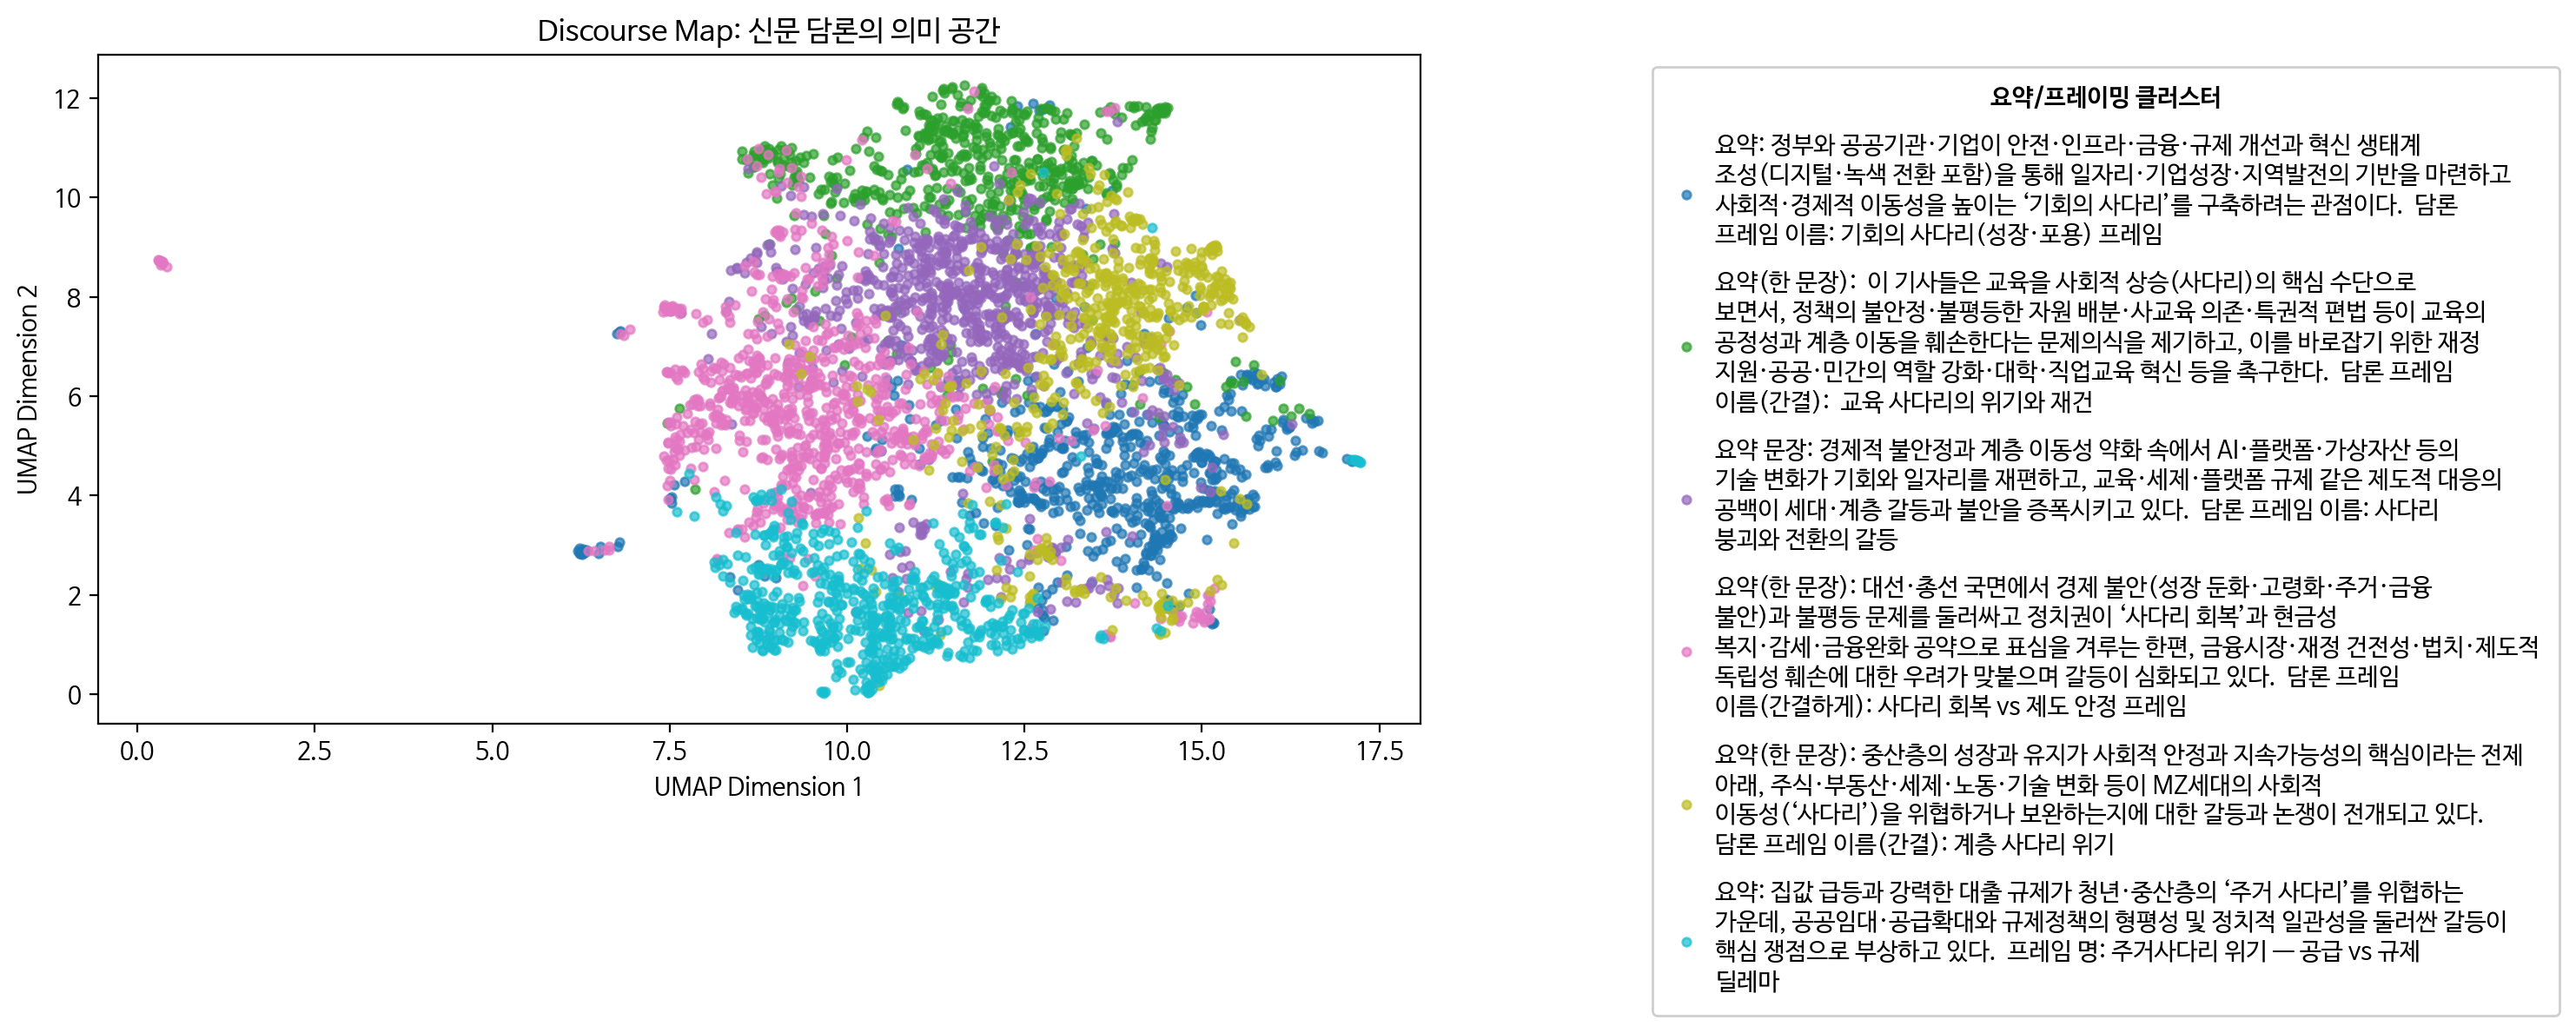

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from textwrap import fill

# 공백 기준 줄바꿈 + 긴 단어도 강제 줄바꿈
def wrap_label(s, width=42):
    return fill(str(s), width=width, break_long_words=True, break_on_hyphens=False)

# figure 레이아웃
fig = plt.figure(figsize=(18, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 2])  # 왼쪽:플롯 / 오른쪽:레전드
ax = fig.add_subplot(gs[0, 0])
ax_leg = fig.add_subplot(gs[0, 1])
ax_leg.axis('off')  # 레전드 전용 축(눈금/테두리 숨김)

# 산점도
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters1))
for i, color in zip(range(num_clusters1), colors):
    subset = df_filtered[df_filtered["cluster"] == i]
    ax.scatter(subset["x"], subset["y"], color=color,
               label=cluster_labels[i], alpha=0.7, s=12)

ax.set_title("🗺️ Discourse Map: 신문 담론의 의미 공간")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")

handles, labels = ax.get_legend_handles_labels() # 레전드(오른쪽 패널)
labels_wrapped = [wrap_label(l, width=46) for l in labels] # 긴 문장 줄바꿈

# n열로 나누고 싶으면 ncol 변경 (마지막 줄 튐 방지 위해 더미 핸들 채우기)
ncol = 1
rem = (-len(handles)) % ncol
if rem:
    for _ in range(rem):
        handles.append(Line2D([], [], linestyle='None', alpha=0))
        labels_wrapped.append(' ')

leg = ax_leg.legend(handles, labels_wrapped,
                    loc='upper left', bbox_to_anchor=(0, 1),
                    ncol=ncol,
                    frameon=True, fancybox=True, framealpha=0.95,
                    borderpad=0.8, labelspacing=0.9,
                    handlelength=1.2, handletextpad=0.6)

# 레전드 내부 멀티라인 텍스트를 왼쪽 정렬
for t in leg.get_texts():
    t.set_multialignment('left')

# 옵션: 레전드 박스에 제목 달기
leg.set_title("요약/프레이밍 클러스터", prop={'weight': 'bold'})

In [ ]:
# GPT의 "AI 담론 재현" 단계 추가

# 특정 주제를 입력받아, 그 주제에 대한 'AI 담론 재현' 문장을 생성하는 함수
def ai_reconstruction(prompt_topic):
    prompt = f"""
    '{prompt_topic}'라는 주제에 대해 당신의 의견을 서술하세요.
    사회적 담론에서 자주 등장하는 표현을 사용하되,
    당신이 보기에 가장 '공정하고 중립적'이라고 생각되는 방식으로 답변하세요.
    """
    response = client.chat.completions.create(
        model="gpt-5-mini", # 사용할 LLM 모델 이름 (실제 사용 시 존재하는 모델명으로 교체 필요)
        messages=[{"role": "user", "content": prompt}] # 위에서 만든 프롬프트를 user 역할로 전달
    )
    return response.choices[0].message.content.strip() # 모델이 생성한 첫 번째 응답의 텍스트를 공백 제거 후 반환

ai_reconstructions = {} # 클러스터별 AI 재현 문장을 저장할 딕셔너리

for i, frame in cluster_labels.items():  # cluster_labels: {클러스터 번호: 사람이 붙인 프레임 설명 문자열}
    topic = frame.split("\n")[0]  # 여러 줄 중 첫 줄만을 '주제 문구'로 사용 (예: "청년 불평등 인식")
    ai_text = ai_reconstruction(topic) # 해당 주제에 대해 AI에게 공정·중립적 담론을 생성하게 요청
    ai_reconstructions[i] = ai_text  # 클러스터 번호 i를 키로 하여 결과 텍스트를 딕셔너리에 저장
    print(f"\n🤖 [AI 재현] {topic}\n{ai_text}\n") # 콘솔에 클러스터 주제와, 그에 대한 AI의 재현 텍스트를 함께 출력


🤖 [AI 재현] 요약: 정부와 공공기관·기업이 안전·인프라·금융·규제 개선과 혁신 생태계 조성(디지털·녹색 전환 포함)을 통해 일자리·기업성장·지역발전의 기반을 마련하고 사회적·경제적 이동성을 높이는 ‘기회의 사다리’를 구축하려는 관점이다.
요약된 정책 관점은 타당성이 있고 바람직한 목표를 담고 있습니다. 안전·인프라·금융·규제 개선과 디지털·녹색 전환을 통한 혁신 생태계 조성은 일자리 창출, 기업 성장, 지역 발전의 기반을 다지는 핵심 수단이며, 궁극적으로 사회적·경제적 이동성(기회의 사다리)을 높이는 데 기여할 수 있습니다. 다만 성공적이고 공정한 실현을 위해선 몇 가지 점을 균형 있게 고려해야 합니다.

장점
- 포용적 성장: 공공 인프라와 규제 개선은 기업의 창업·확장 비용을 낮추고 일자리 접근성을 높여 사회 전반의 기회를 확대합니다.
- 지역균형 발전: 인프라·금융 지원과 지역 특화 혁신 생태계는 수도권 집중을 완화하고 지방의 경쟁력을 제고할 수 있습니다.
- 구조전환 대응: 디지털·녹색 전환은 장기적 경쟁력과 지속가능성을 확보하며, 신산업과 고부가가치 일자리로의 이동을 촉진합니다.
- 사회적 안전망과 연계 시 불확실성 완화: 재교육·직업전환 지원 및 사회안전망 강화는 노동시장 충격을 완충해 사회적 이동성을 높입니다.

우려와 한계
- 불평등의 심화 가능성: 정책 효과가 교육·자본이 많은 집단에 편중되면 오히려 격차가 커질 수 있습니다(디지털 격차, 지역 간 격차 등).
- 집행과정의 비효율·부패 위험: 자금 배분과 규제 완화 과정에서 형평성이 훼손될 우려가 있습니다.
- 단기적 비용과 재정제약: 대규모 인프라·전환 투자는 단기적 재정 부담과 조세·재정정책의 부담을 초래할 수 있습니다.
- 전환의 고용충격: 산업구조 변화는 일부 노동자에겐 일시적 혹은 장기적 실직을 가져올 수 있으므로 재교육·재취업 지원이 필수입니다.

공정하고 중립적인 실행 원칙(권고)
- 포용성 우선: 정책 설계 단계부터 취약계층·지역을 우선 고려하고, 디지털 포용·지역 맞춤형

In [ ]:
# 인간 담론 vs ai 담론

comparison = pd.DataFrame({
    "Cluster": list(cluster_labels.keys()),
    "인간 담론 프레임": [cluster_labels[i] for i in cluster_labels],
    "AI 재현 담론": [ai_reconstructions[i] for i in ai_reconstructions]
})

comparison

,Cluster,인간 담론 프레임,AI 재현 담론
0,0,요약: 정부와 공공기관·기업이 안전·인프라·금융·규제 개선과 혁신 생태계 조성(디지...,요약된 정책 관점은 타당성이 있고 바람직한 목표를 담고 있습니다. 안전·인프라·금융...
1,1,요약(한 문장): \n이 기사들은 교육을 사회적 상승(사다리)의 핵심 수단으로 보면...,요약(한 문장): 특정 주제를 한 문장으로 요약하는 일은 핵심을 명료하게 전달하고 ...
2,2,요약 문장: 경제적 불안정과 계층 이동성 약화 속에서 AI·플랫폼·가상자산 등의 기...,요약문이 짚은 문제는 오늘날 많은 사회에서 현실로 확인되는 복합적 현상입니다. 경제...
3,3,요약(한 문장):\n대선·총선 국면에서 경제 불안(성장 둔화·고령화·주거·금융 불안...,요약(한 문장): 핵심을 간결하게 전달하되 사실과 맥락을 존중하고 다양한 관점을 균...
4,4,요약(한 문장): 중산층의 성장과 유지가 사회적 안정과 지속가능성의 핵심이라는 전제...,요약문에서 전제한 ‘중산층의 성장과 유지가 사회적 안정과 지속가능성의 핵심’이라는 ...
5,5,요약: 집값 급등과 강력한 대출 규제가 청년·중산층의 ‘주거 사다리’를 위협하는 가...,"문제의식 요약\n주택가격의 급등과 함께 가계대출에 대한 엄격한 규제가 병행되면서, ..."


In [ ]:
print(comparison['인간 담론 프레임'][0])

요약: 정부와 공공기관·기업이 안전·인프라·금융·규제 개선과 혁신 생태계 조성(디지털·녹색 전환 포함)을 통해 일자리·기업성장·지역발전의 기반을 마련하고 사회적·경제적 이동성을 높이는 ‘기회의 사다리’를 구축하려는 관점이다.

담론 프레임 이름: 기회의 사다리(성장·포용) 프레임


In [ ]:
print(comparison['AI 재현 담론'][0])

요약된 정책 관점은 타당성이 있고 바람직한 목표를 담고 있습니다. 안전·인프라·금융·규제 개선과 디지털·녹색 전환을 통한 혁신 생태계 조성은 일자리 창출, 기업 성장, 지역 발전의 기반을 다지는 핵심 수단이며, 궁극적으로 사회적·경제적 이동성(기회의 사다리)을 높이는 데 기여할 수 있습니다. 다만 성공적이고 공정한 실현을 위해선 몇 가지 점을 균형 있게 고려해야 합니다.

장점
- 포용적 성장: 공공 인프라와 규제 개선은 기업의 창업·확장 비용을 낮추고 일자리 접근성을 높여 사회 전반의 기회를 확대합니다.
- 지역균형 발전: 인프라·금융 지원과 지역 특화 혁신 생태계는 수도권 집중을 완화하고 지방의 경쟁력을 제고할 수 있습니다.
- 구조전환 대응: 디지털·녹색 전환은 장기적 경쟁력과 지속가능성을 확보하며, 신산업과 고부가가치 일자리로의 이동을 촉진합니다.
- 사회적 안전망과 연계 시 불확실성 완화: 재교육·직업전환 지원 및 사회안전망 강화는 노동시장 충격을 완충해 사회적 이동성을 높입니다.

우려와 한계
- 불평등의 심화 가능성: 정책 효과가 교육·자본이 많은 집단에 편중되면 오히려 격차가 커질 수 있습니다(디지털 격차, 지역 간 격차 등).
- 집행과정의 비효율·부패 위험: 자금 배분과 규제 완화 과정에서 형평성이 훼손될 우려가 있습니다.
- 단기적 비용과 재정제약: 대규모 인프라·전환 투자는 단기적 재정 부담과 조세·재정정책의 부담을 초래할 수 있습니다.
- 전환의 고용충격: 산업구조 변화는 일부 노동자에겐 일시적 혹은 장기적 실직을 가져올 수 있으므로 재교육·재취업 지원이 필수입니다.

공정하고 중립적인 실행 원칙(권고)
- 포용성 우선: 정책 설계 단계부터 취약계층·지역을 우선 고려하고, 디지털 포용·지역 맞춤형 지원을 병행해야 합니다.
- 증거기반 정책: 파일럿·평가를 통한 점진적 확대, 데이터에 기반한 성과 측정과 정책 수정이 필요합니다.
- 투명한 자원배분: 예산 집행과 보조금·인센티브 제공 시 투명성·책임성을 강화해 형평성 문제를 줄입니다.
- 